In [1]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import tifffile as tiff
import pandas as pd

# Formula from paper

In [2]:
def radialcenter(I):
    # Number of grid points
    Ny, Nx = I.shape
    # grid coordinates are -n:n, where Nx (or Ny) = 2*n+1
    # grid midpoint coordinates are -n+0.5:n-0.5;
    xm_onerow = np.arange(-(Nx-1)/2.0+0.5, (Nx)/2.0-0.5)
    xm = np.tile(xm_onerow, (Ny-1, 1))

    ym_onecol = np.arange(-(Ny-1)/2.0+0.5, (Ny)/2.0-0.5)
    ym = np.tile(ym_onecol, (Nx-1, 1)).T
    # Calculate derivatives along 45-degree shifted coordinates (u and v)
    dIdu = I[:-1, 1:] - I[1:, :-1]
    dIdv = I[:-1, :-1] - I[1:, 1:]

    # Smoothing
    # h = np.ones((3, 3)) / 9  # simple 3x3 averaging filter
    # fdu = convolve2d(dIdu, h, mode='same')
    # fdv = convolve2d(dIdv, h, mode='same')
    fdu = dIdu
    fdv = dIdv
    
    dImag2 = fdu**2 + fdv**2  # gradient magnitude, squared

    # Slope of the gradient
    m = -(fdv + fdu) / (fdu - fdv)

    # Replace NaNs
    m = np.nan_to_num(m, nan=0.0, posinf=10.0*max(m[np.isfinite(m)]), neginf=-10.0*max(m[np.isfinite(m)]))

    # Shorthand "b"
    b = ym - m * xm

    # Weighting
    sdI2 = np.sum(dImag2)
    xcentroid = np.sum(dImag2 * xm) / sdI2
    ycentroid = np.sum(dImag2 * ym) / sdI2
    w = dImag2 / np.sqrt((xm - xcentroid)**2 + (ym - ycentroid)**2)

    # least-squares minimization
    xc, yc = lsradialcenterfit(m, b, 1)

    # Return output relative to upper left coordinate
    xc = xc + (Nx)/2.0
    yc = yc + (Ny)/2.0

    # A rough measure of the particle width
    Isub = I - np.min(I)
    px, py = np.meshgrid(np.arange(1, Nx+1), np.arange(1, Ny+1))
    xoffset = px - xc
    yoffset = py - yc
    r2 = xoffset**2 + yoffset**2
    sigma = np.sqrt(np.sum(Isub * r2) / np.sum(Isub)) / 2

    return xc, yc, sigma

def lsradialcenterfit(m, b, w):
    # least squares solution to determine the radial symmetry center
    wm2p1 = w / (m**2 + 1)
    sw = np.sum(wm2p1)
    smmw = np.sum(m**2 * wm2p1)
    smw = np.sum(m * wm2p1)
    smbw = np.sum(m * b * wm2p1)
    sbw = np.sum(b * wm2p1)
    det = smw**2 - smmw * sw
    xc = (smbw * sw - smw * sbw) / det
    yc = (smbw * smw - smmw * sbw) / det

    return xc, yc

# Test on real image

In [24]:
im_w1 = tiff.imread('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/images/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB_w1.tif')

In [25]:
im_w1.shape

(181, 5, 512, 512)

In [26]:
frame = -1
imw1max = np.max(im_w1, axis=1)


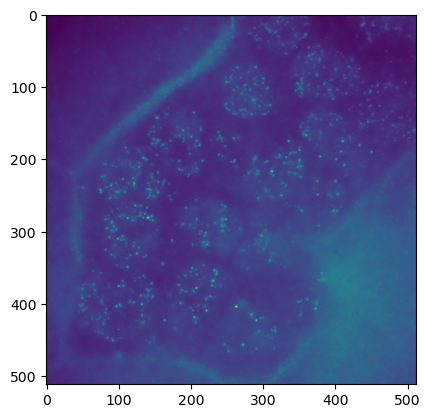

In [27]:
plt.imshow(imw1max[frame])

In [28]:
import sys
sys.path.append('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/ipa/src/')
import hmax_utils as hu
from tqdm import tqdm

In [10]:
sd_w1 = []
for frame in tqdm(np.random.randint(0,imw1max.shape[0],size=50)):
    sd_w1.append(hu.compute_h_param(im=imw1max,frame=frame))

sd_w1 = [x for x in sd_w1 if x > 0]

100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


In [11]:
from skimage.morphology import extrema

In [12]:
frame = -1
n = 6
sd = np.mean(sd_w1)

im_mask = extrema.h_maxima(im_w1[frame],h=n*int(sd))

# extract the points and fit gaussian
z,y,x = np.nonzero(im_mask)

In [13]:
array = np.array([y,x]).T
array = set([tuple(i) for i in array])
y,x = zip(*array)

In [572]:
def crop_img(im, x, y, size):
    r_coord = int(y)
    c_coord = int(x)
    crop_size = size
    start_dim1 = np.max([int(np.round(r_coord - crop_size // 2)), 0])
    if start_dim1 < len(im) - crop_size:
        end_dim1 = start_dim1 + crop_size
    else:
        start_dim1 = len(im) - crop_size
        end_dim1 = len(im)

    start_dim2 = np.max([int(np.round(c_coord - crop_size // 2)), 0])
    if start_dim2 < len(im) - crop_size:
        end_dim2 = start_dim2 + crop_size
    else:
        start_dim2 = len(im) - crop_size
        end_dim2 = len(im)

    crop = im[start_dim1:end_dim1, start_dim2:end_dim2]
    crop = np.array(crop, dtype=np.float32)
    return crop,start_dim1,start_dim2

In [627]:
loc = np.zeros((len(x), 3))
crops = []
x_crop = []
y_crop = []

for i,(x_,y_) in enumerate(zip(x, y)):
    crop, start_dim1, start_dim2 = crop_img(imw1max[frame], x_, y_, 5)
    crops.append(crop)
    loc[i] = radialcenter(crop)
    #print(loc[i])
    x_crop.append(loc[i,0])
    y_crop.append(loc[i,1])
    loc[i, 0] = loc[i, 0]+ start_dim1
    loc[i, 1] = loc[i, 1] + start_dim2

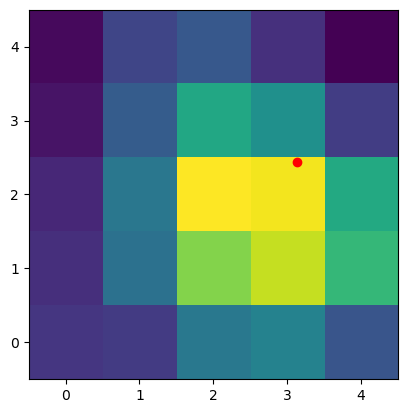

In [630]:
crop_id = 6

plt.imshow(crops[crop_id],origin='lower')
plt.scatter(x_crop[crop_id],y_crop[crop_id],c='r')

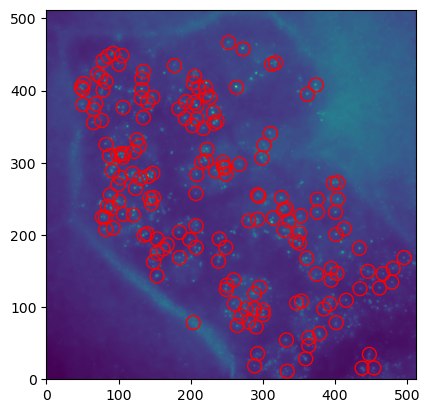

In [401]:
plt.scatter(loc[:,0], loc[:,1],edgecolors='r',facecolors='none',s=100)
plt.xlim(0,512)
plt.ylim(0,512)
plt.imshow(imw1max[frame])

In [382]:
## Gaussian fitting

In [14]:
import scipy.optimize as opt
from skimage.morphology import extrema
from multiprocessing import Pool

In [15]:
def gauss_3d(xyz, amplitude, x0, y0, z0, sigma_xy, sigma_z, offset):
    """3D gaussian."""
    x, y, z = xyz
    x0 = float(x0)
    y0 = float(y0)
    z0 = float(z0)

    gauss = offset + amplitude * np.exp(
        -(
            ((x - x0) ** (2) / (2 * sigma_xy ** (2)))
            + ((y - y0) ** (2) / (2 * sigma_xy ** (2)))
            + ((z - z0) ** (2) / (2 * sigma_z ** (2)))
        )
    )
    return gauss

EPS = 1e-4

def find_start_end(coord, img_size, crop_size):
    start_dim = np.max([int(np.round(coord - crop_size // 2)), 0])
    if start_dim < img_size - crop_size:
        end_dim = start_dim + crop_size
    else:
        start_dim = img_size - crop_size
        end_dim = img_size

    return start_dim, end_dim


def gauss_single_spot(
    image: np.ndarray,
    c_coord: float,
    r_coord: float,
    z_coord: float,
    crop_size= 4 ,
    crop_size_z= 4,
):
    """Gaussian prediction on a single crop centred on spot."""

    start_dim1, end_dim1 = find_start_end(c_coord, image.shape[1], crop_size)
    start_dim2, end_dim2 = find_start_end(r_coord, image.shape[2], crop_size)
    start_dim3, end_dim3 = find_start_end(z_coord, image.shape[0], crop_size_z)

    crop = image[start_dim3:end_dim3,start_dim1:end_dim1, start_dim2:end_dim2]

    x = np.arange(0, crop.shape[1], 1)
    y = np.arange(0, crop.shape[2], 1)
    z = np.arange(0, crop.shape[0], 1)
    zz,xx, yy = np.meshgrid(z,x, y)

    # Guess intial parameters
    x0 = int(crop.shape[1] // 2)  # Center of gaussian, middle of the crop
    y0 = int(crop.shape[2] // 2)  # Center of gaussian, middle of the crop
    z0 = int(crop.shape[0] // 2)  # Center of gaussian, middle of the crop
    sigma = max(*crop.shape[:-1]) * 0.1  # SD of gaussian, 10% of the crop
    sigmaz = crop.shape[-1] * 0.1  # SD of gaussian, 10% of the crop
    amplitude_max = max(
        np.max(crop) / 2, np.min(crop)
    )  # Height of gaussian, maximum value
    initial_guess = [amplitude_max, x0, y0, z0, sigma, sigmaz, 0]

    # Parameter search space bounds
    lower = [np.min(crop), 0, 0, 0, 0, 0, -np.inf]
    upper = [
        np.max(crop) + EPS,
        crop_size,
        crop_size,
        crop_size_z,
        np.inf,
        np.inf,
        np.inf,
    ]
    bounds = [lower, upper]
    try:
        popt, pcov = opt.curve_fit(
            gauss_3d,
            (xx.ravel(), yy.ravel(), zz.ravel()),
            crop.ravel(),
            p0=initial_guess,
            bounds=bounds,
        )
        sd = np.sqrt(np.diag(pcov))
    except RuntimeError:
        print('Runtime')
        return r_coord, c_coord, z_coord,0,0,0

    x0 = popt[1] + start_dim2
    y0 = popt[2] + start_dim1
    z0 = popt[3] + start_dim3
    sd_x = sd[1]
    sd_y = sd[2]
    sd_z = sd[3]

    # If predicted spot is out of the border of the image
    if x0 >= image.shape[1] or y0 >= image.shape[2] or z0 >= image.shape[0]:
        print('Out of border')
        return r_coord, c_coord, z_coord,0,0,0

    return x0, y0, z0,sd_x, sd_y, sd_z

In [16]:
array = np.array([z,y,x]).T
array = set([tuple(i) for i in array])
z,y,x = zip(*array)

k = [(im_w1[frame],y[i],x[i],z[i]) for i in range(len(x))]

threads = 5
with Pool(processes=threads) as p:
    x_s,y_s,z_s,sdx_fit,sdy_fit,sdz_fit = zip(*(p.starmap(gauss_single_spot,k)))

Out of border
Out of border
Out of border


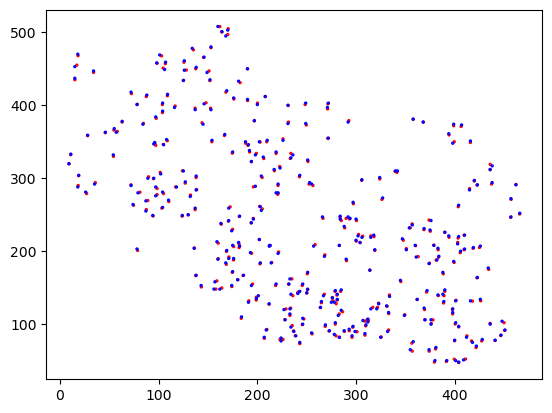

In [409]:
plt.scatter(y_s, x_s,edgecolors='r',facecolors='none',s=2)
plt.scatter(y, x,edgecolors='b',facecolors='none',s=2)

In [405]:
d = np.sqrt((np.array(x)-np.array(x_s))**2 + (np.array(y)-np.array(y_s))**2)
dx = (np.array(x)-np.array(x_s))
dy = (np.array(y)-np.array(y_s))

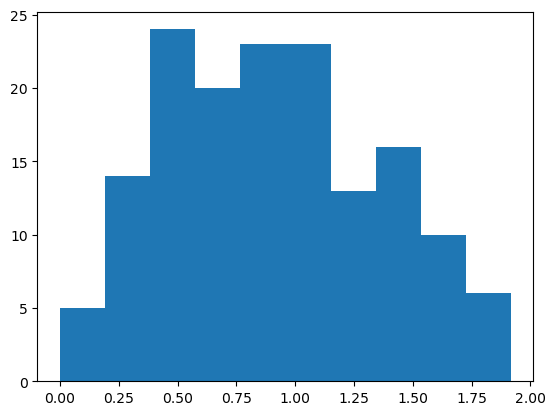

In [410]:
plt.hist(d[d<2])
plt.show()

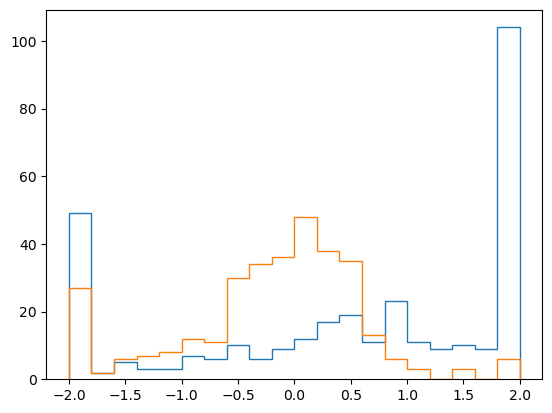

In [408]:
plt.hist(dx, bins=20,histtype='step',label='dx')
plt.hist(dy, bins=20,histtype='step',label='dy')
plt.show()

# Re-writting the formula

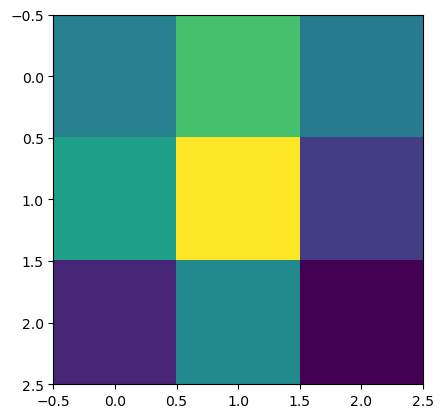

In [499]:
crop = crops[3]+ 0.5
plt.imshow(crops[3])

In [510]:
grid_x = np.arange(0.5, crop.shape[1], 0.5)
grid_y = np.arange(0.5, crop.shape[0], 0.5)

coords = np.meshgrid(grid_x, grid_y)

In [561]:
I = crops[3].astype(float)

# compute derivative at 45 degree angle
gradient = np.zeros((I.shape[0]-1,I.shape[0]-1,2))
points = np.zeros((I.shape[0]-1,I.shape[0]-1,2))


for c,i in enumerate(range(0, I.shape[0]-1)):
    for j in range(0, I.shape[1]-1):
        gradient[i][j][0] = (I[i+1][j+1] - I[i][j])
        gradient[i][j][1] = (I[i][j+1] - I[i+1][j])
        # points[i][j][0] = i+0.5
        # points[i][j][1] = j+0.5

fdu = gradient[:,:,0]
fdv = gradient[:,:,1]
# h = np.ones((3, 3)) / 9  # simple 3x3 averaging filter
# fdu = convolve2d(dIdu, h, mode='same')
# fdv = convolve2d(dIdv, h, mode='same')
# dImag2 = fdu**2 + fdv**2  # gradient magnitude, squared

# # Slope of the gradient
m = (fdv + fdu) / (fdu - fdv)

b = ym - m * xm

array([[  1.68874172, -16.28      ],
       [ -0.82700422,   1.84487805]])

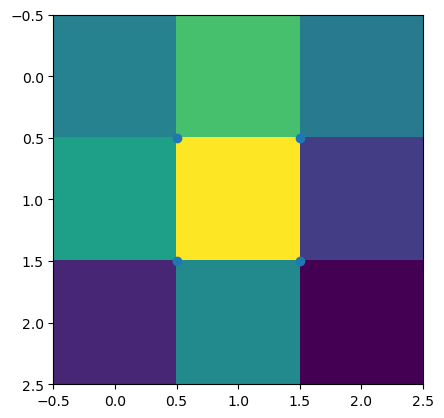

In [531]:
plt.scatter(points[:,:,0],points[:,:,1])
plt.imshow(I)

# Testing another implementation

In [81]:
import warnings
from scipy import ndimage as ndi
def rs(psf_image):
    """
    Localize the center of a PSF using the radial 
    symmetry method.
    Originally conceived by the criminally underrated
    Parasarathy R Nature Methods 9, pgs 724–726 (2012).
    args
    ----
        psf_image : 2D ndarray, PSF subwindow
    returns
    -------
        float y estimate, float x estimate
    """
    # Get the size of the image frame and build
    # a set of pixel indices to match
    N, M = psf_image.shape
    N_half = N // 2
    M_half = M // 2
    ym, xm = np.mgrid[:N-1, :M-1]
    ym = ym - N_half + 0.5
    xm = xm - M_half + 0.5 
    
    # Calculate the diagonal gradients of intensities across each
    # corner of 4 pixels
    dI_du = psf_image[:N-1, 1:] - psf_image[1:, :M-1]
    dI_dv = psf_image[:N-1, :M-1] - psf_image[1:, 1:]
    
    # Smooth the image to reduce the effect of noise, at the cost
    # of a little resolution
    fdu = ndi.uniform_filter(dI_du, 3)
    fdv = ndi.uniform_filter(dI_dv, 3)
    #fdu = dI_du
    #fdv = dI_dv
    
    dI2 = (fdu ** 2) + (fdv ** 2)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        m = -(fdv + fdu) / (fdu - fdv)
        
    # For pixel values that blow up, instead set them to a very
    # high float
    m[np.isinf(m)] = 9e9
    
    b = ym - m * xm

    sdI2 = dI2.sum()
    ycentroid = (dI2 * ym).sum() / sdI2
    xcentroid = (dI2 * xm).sum() / sdI2
    w = dI2 / np.sqrt((xm - xcentroid)**2 + (ym - ycentroid)**2)

    # Correct nan / inf values
    w[np.isnan(m)] = 0
    b[np.isnan(m)] = 0
    m[np.isnan(m)] = 0

    # Least-squares analytical solution to the point of 
    # maximum radial symmetry, given the slopes at each
    # edge of 4 pixels
    wm2p1 = w / ((m**2) + 1)
    sw = wm2p1.sum()
    smmw = ((m**2) * wm2p1).sum()
    smw = (m * wm2p1).sum()
    smbw = (m * b * wm2p1).sum()
    sbw = (b * wm2p1).sum()
    det = (smw ** 2) - (smmw * sw)
    xc = (smbw*sw - smw*sbw)/det
    yc = (smbw*smw - smmw*sbw)/det

    # Adjust coordinates so that they're relative to the
    # edge of the image frame
    yc = (yc + (N + 1) / 2.0) - 1
    xc = (xc + (M + 1) / 2.0) - 1

    return yc, xc


def get_subpixels_in_frame(frame, spots, box=9):
    """
    Given a 2D array `frame` and a Pandas DataFrame `spots` containing x and y coordinates, this function extracts a 
    square region of size `box` centered at each spot and returns the subpixel coordinates of the spot in the 
    corresponding region. The subpixel coordinates are relative to the top-left corner of the region and are returned 
    as a 2xN array, where N is the number of spots.
    
    Parameters
    ----------
    frame : numpy.ndarray
        A 2D numpy array representing the image frame.
    spots : pandas.DataFrame
        A Pandas DataFrame containing x and y columns representing the spot coordinates.
    box : int, optional
        An integer representing the size of the square region to extract around each spot. Default is 9.
    
    Returns
    -------
    numpy.ndarray
        A 2xN numpy array containing the subpixel coordinates of each spot in the corresponding region.
    """
    #H, W 
    H, W = frame.shape
    subpixels = np.zeros((2,len(spots)), dtype=np.float_)
    indexer = box // 2
    for n, (x, y) in enumerate(zip(spots.x, spots.y)):
        xl = x-indexer if x-indexer >= 0 else 0
        xh = x+indexer if x+indexer < W else W
        yl = y-indexer if y-indexer >= 0 else 0
        yh = y+indexer if y+indexer < H else H-1

        s_i = frame[yl:yh, xl:xh]
        yc, xc = rs(s_i)
        subpixels[0, n] = yc + yl + 1
        subpixels[1, n] = xc + xl + 1
    return subpixels,s_i,yc,xc

In [82]:
spots = pd.DataFrame({'x':x,'y':y})

In [131]:
subpixels,crop,y_f,x_f = get_subpixels_in_frame(imw1max[frame], spots, box=4)

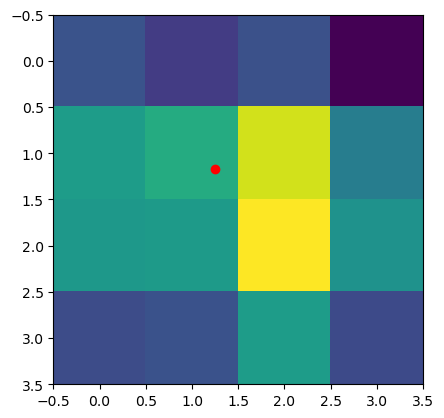

In [132]:
plt.imshow(crop)
plt.scatter(y_f,x_f,c='r')


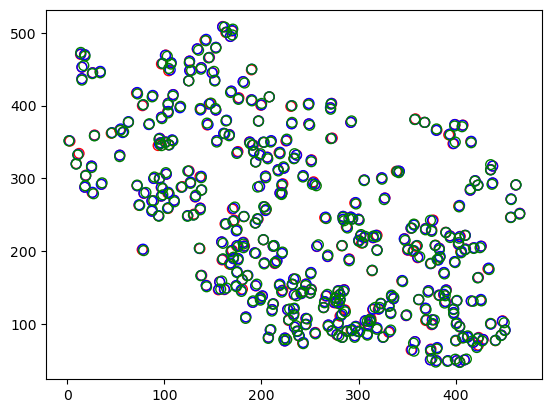

In [70]:
plt.scatter(subpixels[0], subpixels[1],edgecolors='r',facecolors='none',s=50)
plt.scatter(y, x,edgecolors='b',facecolors='none',s=50)
plt.scatter(y_s, x_s,edgecolors='g',facecolors='none',s=50)

(450.0, 470.0)

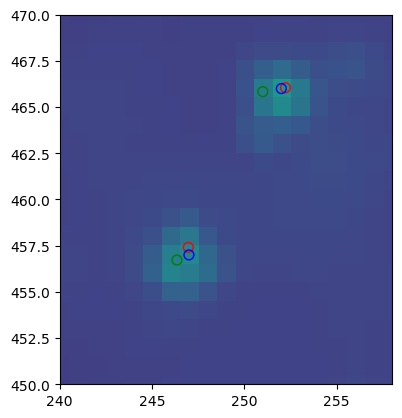

In [133]:
plt.imshow(imw1max[frame],origin='lower')
plt.scatter(subpixels[1], subpixels[0],edgecolors='r',facecolors='none',s=50)
plt.scatter(x,y, edgecolors='b',facecolors='none',s=50)
plt.scatter(x_s,y_s,edgecolors='g',facecolors='none',s=50)
# plt.xlim(182,195)
# plt.ylim(280,300)

# plt.xlim(370,390)
# plt.ylim(350,372)

plt.xlim(240,258)
plt.ylim(450,470)

In [71]:
d = np.sqrt((np.array(y_s)-np.array(subpixels[0]))**2 + (np.array(x_s)-np.array(subpixels[1]))**2)

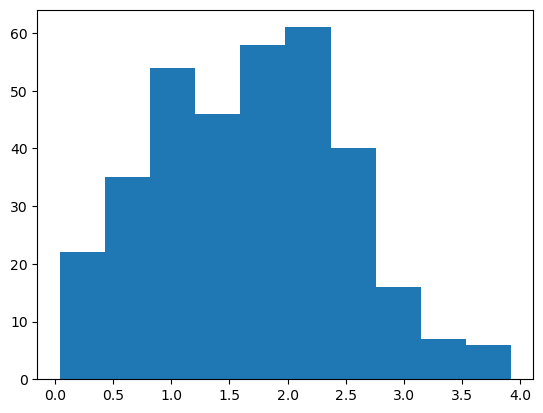

In [72]:
plt.hist(d)
plt.show()